# Hello, PyTorch! -- MNIST Handwritten Digits

- https://en.wikipedia.org/wiki/MNIST_database

# Load Datasets

In [2]:
import torch
from torchvision import datasets, transforms

In [3]:
x = datasets.MNIST('data', download=True)
x[0]

(<PIL.Image.Image image mode=L size=28x28>, 5)

In [4]:
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

In [5]:
dataset1 = datasets.MNIST('data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=64)

dataset2 = datasets.MNIST('data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(dataset2, batch_size=1000)

In [6]:
i, x = next(enumerate(train_loader))
x[0].shape

torch.Size([64, 1, 28, 28])

# View Image

In [7]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

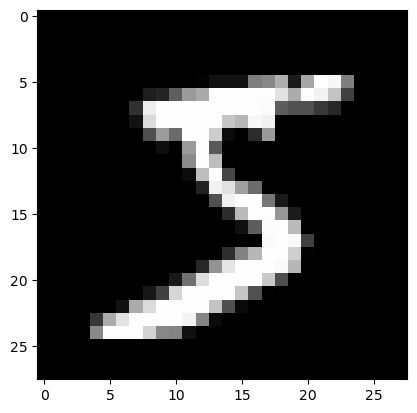

In [8]:
i, x = next(enumerate(train_loader))
x2 = np.squeeze(x[0][0])
plt.imshow(x2, cmap='gray')

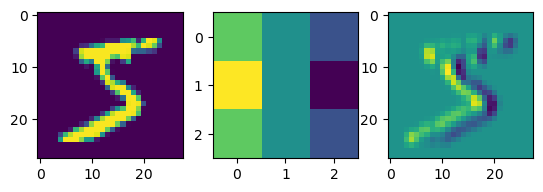

In [9]:
kernel = np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]])
y = scipy.ndimage.convolve(x2, kernel)

fig, axes = plt.subplots(1,3)
axes[0].imshow(x2)
axes[1].imshow(kernel)
axes[2].imshow(y)

# Create Network

In [10]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchinfo import summary

In [11]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [12]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
summary(network, input_size=(1,28,28))

/opt/anaconda3/envs/pytorch/lib/python3.13/site-packages/torch/nn/functional.py:1545: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn(
/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_96224/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [1, 10]                   --
├─Conv2d: 1-1                            [10, 24, 24]              260
├─Conv2d: 1-2                            [20, 8, 8]                5,020
├─Dropout2d: 1-3                         [20, 8, 8]                --
├─Linear: 1-4                            [1, 50]                   16,050
├─Linear: 1-5                            [1, 10]                   510
Total params: 21,840
Trainable params: 21,840
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.88
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.09
Estimated Total Size (MB): 0.15

# Visualize Weights

In [13]:
def visualize():
    i, x = next(enumerate(test_loader))
    x2 = np.squeeze(x[0][0])
    weights = network.conv1.weight.data
    
    fig, axes = plt.subplots(10,2)
    for i in range(10):
        weights_np = np.squeeze(weights.numpy()[i,0,:,:])
        axes[i,0].imshow(weights_np)
        axes[i,1].imshow(scipy.ndimage.convolve(x2, weights_np))

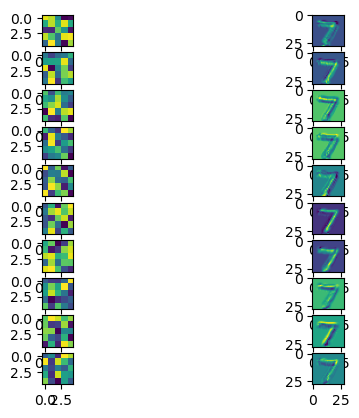

In [14]:
visualize()

# Predict Using Network

In [15]:
i, x = next(enumerate(train_loader))
x[1][:5]

tensor([5, 0, 4, 1, 9])

In [16]:
y = network(x[0])
pred = y.data.max(1)[1]
pred[:5]

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_96224/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


tensor([1, 8, 8, 8, 7])

# First Test and Train

In [17]:
def test():
  network.eval()
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  print('Test accuracy: {:.0f}%\n'.format(100. * correct / len(test_loader.dataset)))

In [18]:
test()

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_96224/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Test accuracy: 10%



In [19]:
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
def train():
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % 100 == 0:
      print('Train loss: {:.6f}'.format(loss.item()))

In [20]:
train()

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_96224/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train loss: 2.277655
Train loss: 1.846093
Train loss: 1.177804
Train loss: 0.827494
Train loss: 0.478109
Train loss: 0.830187
Train loss: 0.464098
Train loss: 0.488732
Train loss: 0.577703
Train loss: 0.447193


# Train Network

In [21]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
for epoch in range(5):
    train()
    test()

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_96224/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train loss: 2.290596
Train loss: 1.817393
Train loss: 0.849549
Train loss: 0.942975
Train loss: 0.645906
Train loss: 0.573891
Train loss: 0.513219
Train loss: 0.488720
Train loss: 0.386608
Train loss: 0.273405
Test accuracy: 94%

Train loss: 0.530182
Train loss: 0.310391
Train loss: 0.361493
Train loss: 0.359413
Train loss: 0.261180
Train loss: 0.353648
Train loss: 0.240480
Train loss: 0.522326
Train loss: 0.435032
Train loss: 0.360503
Test accuracy: 96%

Train loss: 0.310248
Train loss: 0.393509
Train loss: 0.361817
Train loss: 0.300958
Train loss: 0.206797
Train loss: 0.312771
Train loss: 0.389958
Train loss: 0.547950
Train loss: 0.417374
Train loss: 0.293889
Test accuracy: 97%

Train loss: 0.241222
Train loss: 0.240148
Train loss: 0.193690
Train loss: 0.447059
Train loss: 0.301363
Train loss: 0.207575
Train loss: 0.119588
Train loss: 0.274716
Train loss: 0.350523
Train loss: 0.276503
Test accuracy: 97%

Train loss: 0.194363
Train loss: 0.204398
Train loss: 0.192304
Train loss: 0.237

# Inspect Network

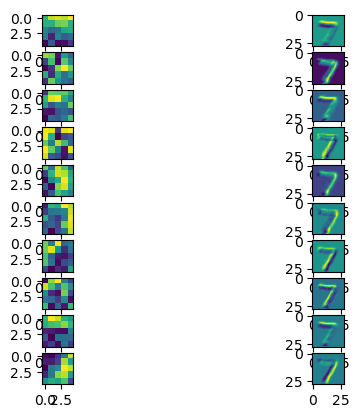

In [22]:
visualize()

In [23]:
i, x = next(enumerate(train_loader))
x[1][:5]

tensor([5, 0, 4, 1, 9])

In [24]:
y = network(x[0])
pred = y.data.max(1)[1]
pred[:5]

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_96224/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


tensor([5, 0, 4, 1, 9])

# How Much Data?

- What is the accuracy using 60,000 images? 30,000? 6,000? 3,000? 600?
- How do the weights looks different when trained with 60,000 vs 600?

In [ ]:
## 60,000

In [28]:
dataset1 = datasets.MNIST('data', train=True, download=True, transform=transform)
dataset1 = torch.utils.data.Subset(dataset1, range(60000))
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=64)

In [29]:
# Create a new network and optimizer each time you try a new training set
network = Net()
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
for epoch in range(5):
    train()
    test()

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_96224/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train loss: 2.306874
Train loss: 2.036125
Train loss: 1.307612
Train loss: 0.883743
Train loss: 0.707028
Train loss: 0.657904
Train loss: 0.583812
Train loss: 0.525830
Train loss: 0.631524
Train loss: 0.395731
Test accuracy: 94%

Train loss: 0.448405
Train loss: 0.393303
Train loss: 0.334530
Train loss: 0.397153
Train loss: 0.342961
Train loss: 0.286889
Train loss: 0.306496
Train loss: 0.456156
Train loss: 0.353049
Train loss: 0.363055
Test accuracy: 96%

Train loss: 0.280297
Train loss: 0.192747
Train loss: 0.212067
Train loss: 0.379776
Train loss: 0.183280
Train loss: 0.360807
Train loss: 0.224988
Train loss: 0.415458
Train loss: 0.388037
Train loss: 0.366757
Test accuracy: 97%

Train loss: 0.177534
Train loss: 0.307017
Train loss: 0.325660
Train loss: 0.232148
Train loss: 0.122714
Train loss: 0.227090
Train loss: 0.138781
Train loss: 0.434783
Train loss: 0.436167
Train loss: 0.273768
Test accuracy: 97%

Train loss: 0.305321
Train loss: 0.242565
Train loss: 0.206512
Train loss: 0.289

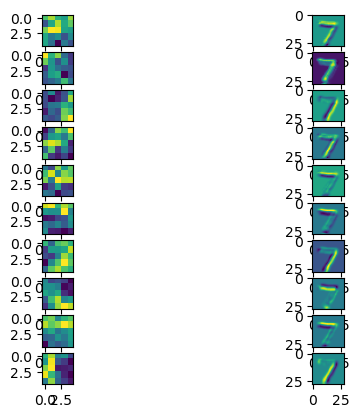

In [30]:
visualize()

In [25]:
dataset1 = datasets.MNIST('data', train=True, download=True, transform=transform)
dataset1 = torch.utils.data.Subset(dataset1, range(30000))
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=64)

In [26]:
# Create a new network and optimizer each time you try a new training set
network = Net()
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
for epoch in range(5):
    train()
    test()

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_96224/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train loss: 2.290210
Train loss: 1.913096
Train loss: 1.048628
Train loss: 0.672025
Train loss: 0.768146
Test accuracy: 92%

Train loss: 0.487659
Train loss: 0.429620
Train loss: 0.446277
Train loss: 0.663683
Train loss: 0.435135
Test accuracy: 95%

Train loss: 0.390772
Train loss: 0.412266
Train loss: 0.281198
Train loss: 0.444575
Train loss: 0.404667
Test accuracy: 96%

Train loss: 0.295076
Train loss: 0.275866
Train loss: 0.374129
Train loss: 0.441843
Train loss: 0.207365
Test accuracy: 97%

Train loss: 0.217878
Train loss: 0.259161
Train loss: 0.289072
Train loss: 0.450044
Train loss: 0.315304
Test accuracy: 97%



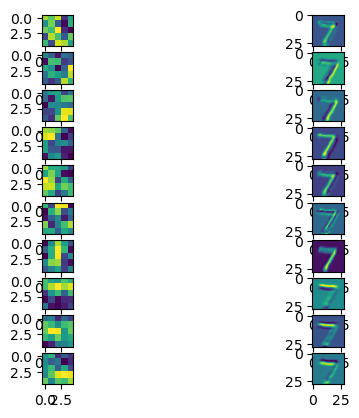

In [27]:
visualize()

In [31]:
dataset1 = datasets.MNIST('data', train=True, download=True, transform=transform)
dataset1 = torch.utils.data.Subset(dataset1, range(6000))
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=64)

In [32]:
# Create a new network and optimizer each time you try a new training set
network = Net()
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
for epoch in range(5):
    train()
    test()

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_96224/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train loss: 2.329205
Test accuracy: 63%

Train loss: 2.050136
Test accuracy: 83%

Train loss: 1.255872
Test accuracy: 87%

Train loss: 0.876721
Test accuracy: 90%

Train loss: 0.702241
Test accuracy: 91%



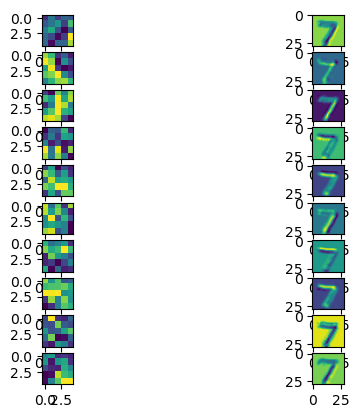

In [33]:
visualize()

In [34]:
dataset1 = datasets.MNIST('data', train=True, download=True, transform=transform)
dataset1 = torch.utils.data.Subset(dataset1, range(3000))
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=64)

In [35]:
# Create a new network and optimizer each time you try a new training set
network = Net()
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
for epoch in range(5):
    train()
    test()

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_96224/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train loss: 2.308549
Test accuracy: 43%

Train loss: 2.241658
Test accuracy: 59%

Train loss: 2.075138
Test accuracy: 70%

Train loss: 1.658743
Test accuracy: 79%

Train loss: 1.127844
Test accuracy: 82%



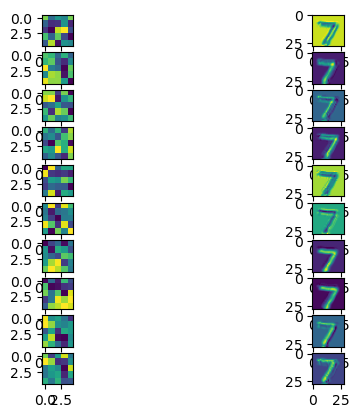

In [36]:
visualize()

In [37]:
dataset1 = datasets.MNIST('data', train=True, download=True, transform=transform)
dataset1 = torch.utils.data.Subset(dataset1, range(600))
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=64)

In [39]:
# Create a new network and optimizer each time you try a new training set
network = Net()
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
for epoch in range(5):
    train()
    test()

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_96224/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train loss: 2.315678
Test accuracy: 17%

Train loss: 2.297038
Test accuracy: 23%

Train loss: 2.246889
Test accuracy: 39%

Train loss: 2.193362
Test accuracy: 42%

Train loss: 2.169412
Test accuracy: 44%



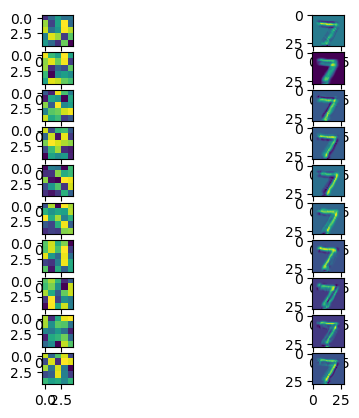

In [40]:
visualize()

In [ ]:
## Question 1a: What is the accuracy using 60,000 images? 30,000? 6,000? 3,000? 600?
# 60,000 - 98%, 30,000 - 97%, 6,000 - 91%, 3,000 - 82%, 600 - 44%

In [ ]:
## Question 1b: How do the weights looks different when trained with 60,000 vs 600?
# There is a lot more color grading in the 60,000 set of images than in the 600 set of images